## Feedforward Multilayer Neural Network

The objective of this section is to implement the backpropagation algorithm (SGD with the chain rule) on a single layer neural network using the sigmoid activation function.

Some initial imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn import preprocessing

import numpy as np

digits = load_digits()

def one_hot(n_classes, y):
    return np.eye(n_classes)[y]


data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')


X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

# Normalise the images
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Y_test = one_hot(10, y_test)
Y_train = one_hot(10, y_train)

- Implement the `sigmoid` and its element-wise derivative `dsigmoid` functions:

$$
sigmoid(x) = \frac{1}{1 + e^{-x}}
$$

$$
dsigmoid(x) = sigmoid(x) \cdot (1 - sigmoid(x))
$$

Plot both the sigmoid and its derivative and compare it to wikipedia or wolframalpha.

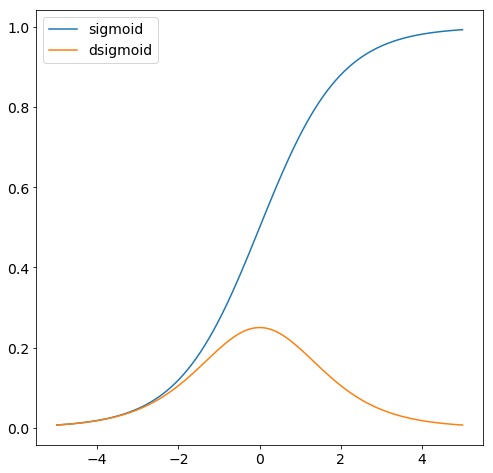

In [2]:
def sigmoid(X):
    # TODO: implement the sigmoid function
    return 1 / (1 + np.exp(-X))


def dsigmoid(X):
    # TODO: derivative of sigmoid
    sig=sigmoid(X)
    return sig * (1 - sig)


x = np.linspace(-5, 5, 100)
plt.plot(x, sigmoid(x), label='sigmoid')
plt.plot(x, dsigmoid(x), label='dsigmoid')
plt.legend(loc='best');

- Implement `forward` and `forward_keep_all` functions for a model with a hidden layer, similar to what we discussed in the slides:
  - $h = sigmoid(\mathbf{W}^h x + b^h)$
  - $y = softmax(\mathbf{W}^o h + b^o)$

Notes: 
  - try to keep the code as similar as possible as the previous one;
  - `forward_keep_activations` is similar to forward, but also returns hidden activations and pre activations;

- update the grad function to compute all gradients; check that the gradients are well defined;

- implement the `train` and `loss` functions.

Bonus: reimplementing all from scratch without looking at the solution of the `LogisticRegression` is an excellent exercise.

In [3]:
# some useful functions from before
EPSILON = 1e-8


def nll(Y_true, Y_pred):
    Y_true, Y_pred = np.atleast_2d(Y_true), np.atleast_2d(Y_pred)
    loglikelihoods = np.sum(np.log(EPSILON + Y_pred) * Y_true, axis=1)
    return -np.mean(loglikelihoods)

def softmax(X):
    exp = np.exp(X)
    return exp / np.sum(exp, axis=-1, keepdims=True)

In [4]:
class NeuralNet():
    """MLP with 1 hidden layer with a sigmoid activation"""

    def __init__(self, input_size, hidden_size, output_size):
        self.W_h = np.random.uniform(
            size=(input_size, hidden_size), high=0.01, low=-0.01)
        self.b_h = np.zeros(hidden_size)
        self.W_o = np.random.uniform(
            size=(hidden_size, output_size), high=0.01, low=-0.01)
        self.b_o =np.zeros(output_size)
        self.output_size = output_size
        
    def forward(self, X):
        # TODO: implement the forward step
        h = sigmoid(np.dot(X, self.W_h) + self.b_h)
        y = softmax(np.dot(h, self.W_o) + self.b_o)
        return y
    
    def forward_keep_activations(self, X):
        # TODO: compute the forward step but return intermediate results as well
        z_h = np.dot(X, self.W_h) + self.b_h
        h = sigmoid(z_h)
        z_o = np.dot(h, self.W_o) + self.b_o
        y = softmax(z_o)
        return y, h, z_h
    
    def loss(self, X, y):
        # TODO: compute the loss of samples X given true labels y
        return nll(one_hot(self.output_size, y), self.forward(X))

    def grad_loss(self, x, y_true):
        # TODO: compute the gradient of sample x with respect to the two Ws and bs
        y, h, z_h = self.forward_keep_activations(x)
        grad_z_o = y - one_hot(self.output_size, y_true)
        
        grad_W_o = np.outer(h, grad_z_o)
        grad_b_o = grad_z_o
        grad_h = np.dot(grad_z_o, np.transpose(self.W_o))
        grad_z_h = grad_h * dsigmoid(z_h)
        grad_W_h = np.outer(x, grad_z_h)
        grad_b_h = grad_z_h
        grads = {"W_h": grad_W_h, "b_h": grad_b_h,
                 "W_o": grad_W_o, "b_o": grad_b_o}
        return grads

    def train(self, x, y, learning_rate):
        # Traditional SGD update on one sample at a time
        grads = self.grad_loss(x, y)
        self.W_h = self.W_h - learning_rate * grads["W_h"]
        self.b_h = self.b_h - learning_rate * grads["b_h"]
        self.W_o = self.W_o - learning_rate * grads["W_o"]
        self.b_o = self.b_o - learning_rate * grads["b_o"]

    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)


In [5]:
n_features = X_train.shape[1]
n_classes = Y_train.shape[1]

n_hidden = 10
model = NeuralNet(n_features, n_hidden, n_classes)

What do things look like before training?

In [6]:
model.loss(X_train, y_train)

2.3027724464060091

In [7]:
model.accuracy(X_train, y_train)

0.098886705959397511

0


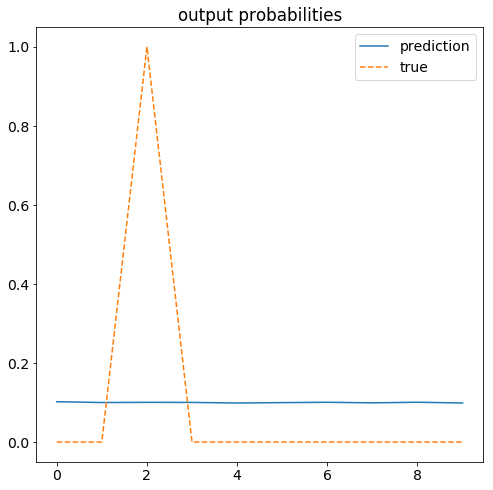

In [8]:
sample_idx = 0
plt.plot(model.forward(X_train[sample_idx]), linestyle='-', label='prediction')
plt.plot(one_hot(10, y_train[sample_idx]), linestyle='--', label='true')
plt.title('output probabilities')
plt.legend()
print(model.predict(X_train[sample_idx]))

In [9]:
losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(15):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.1)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))
    
# rerun the notebook without normalising/scaling the images and performance will be worse

Random init: train loss: 2.3028, train acc: 0.099, test acc: 0.100
Epoch #1, train loss: 0.3755, train acc: 0.904, test acc: 0.867
Epoch #2, train loss: 0.1840, train acc: 0.955, test acc: 0.937
Epoch #3, train loss: 0.1208, train acc: 0.971, test acc: 0.941
Epoch #4, train loss: 0.0927, train acc: 0.978, test acc: 0.952
Epoch #5, train loss: 0.0735, train acc: 0.985, test acc: 0.948
Epoch #6, train loss: 0.0594, train acc: 0.988, test acc: 0.956
Epoch #7, train loss: 0.0509, train acc: 0.991, test acc: 0.959
Epoch #8, train loss: 0.0437, train acc: 0.992, test acc: 0.959
Epoch #9, train loss: 0.0378, train acc: 0.995, test acc: 0.963
Epoch #10, train loss: 0.0329, train acc: 0.997, test acc: 0.963
Epoch #11, train loss: 0.0286, train acc: 0.997, test acc: 0.963
Epoch #12, train loss: 0.0267, train acc: 0.997, test acc: 0.963
Epoch #13, train loss: 0.0232, train acc: 0.997, test acc: 0.967
Epoch #14, train loss: 0.0208, train acc: 0.999, test acc: 0.967
Epoch #15, train loss: 0.0189, t

96% testing accuracy! Not bad.

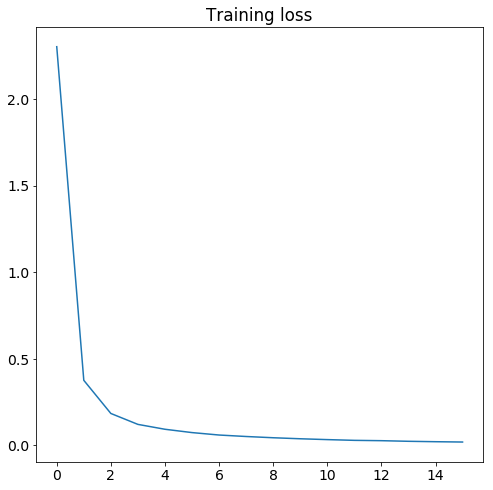

In [10]:
plt.plot(losses)
plt.title("Training loss");

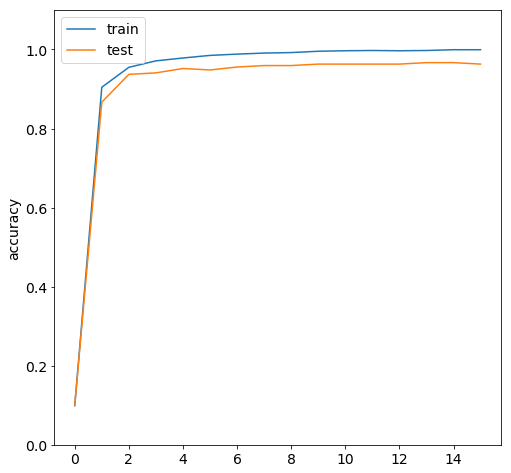

In [11]:
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")
plt.legend(loc='best');

## More please!

Exercises

### Hyper parameters settings

- Experiment with different hyper parameters:
  - learning rate,
  - size of hidden layer,
  - initialization scheme: test with 0 initialization vs uniform,
  - implement other activation functions,
  - implement the support for a second hidden layer.


### Mini-batches

- the current implementations of the `train` and `grad_loss` functions currently only accept a single sample at a time:
    - implement the support for training with a mini-batch of 32 samples at a time instead of one,
    - experiment with different sizes of batches,
    - monitor the norm of the average gradients on the full training set at the end of each epoch.


### Momentum

- Bonus: Implement a optimizer with momentum